In [1]:
import numpy as np
import pandas as pd
import healpy as hp
%config InlineBackend.figure_format = 'retina'
from DS_Planck_Unet import west_val, east_val
from matplotlib import pyplot as plt
from DS_Planck_Unet import load_planck_model, draw_pic_with_mask, draw_pic, val_pix
from DS_healpix_fragmentation import *
from DS_data_transformation import pic2fits, normalize
from DS_detector import *
import os
from astropy.coordinates import SkyCoord
from astropy import units as u
from tqdm.notebook import tqdm
from DS_data_transformation import normalize
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
from scipy.special import logit
from DS_models_stat import stat_orig_cats
from DS_detector import rematch_cat
from matplotlib import cm
from matplotlib.ticker import LinearLocator


In [2]:
all_model = load_planck_model('/home/rt2122/Models/all_found/all_found.ep0034-vl0.009741-l0.008339.hdf5')

In [12]:
df = pd.DataFrame([
    {'RA' : 176.1500, 'DEC' : 19.7589, 'name' : 'Leo'},
    {'RA' : 194.9542, 'DEC': 27.9806, 'name' : 'Coma'},
    {'RA' : 44.2583, 'DEC' : 13.0049, 'name' : 'A399-A401'},
    {'RA' : 201.2500, 'DEC' : -30.0000, 'name' : 'Shapley'},
    {'RA' : 150.507, 'DEC' : +2.31204, 'name' : 'G237.0+42.5'}
])
df['pix2'] = radec2pix(df['RA'], df['DEC'], 2)
df['pix'] = radec2pix(df['RA'], df['DEC'], 2**11)
df

,RA,DEC,name,pix2,pix
0,176.1500,19.75890,Leo,11,12344968
1,194.9542,27.98060,Coma,3,4191272
2,44.2583,13.00490,A399-A401,37,39244338
3,201.2500,-30.00000,Shapley,12,13554718
4,150.5070,2.31204,G237.0+42.5,9,10158405


In [6]:
for pix2 in tqdm(df['pix2']):
    all_data_dict = gen_pics_for_detection(pix2, all_model, step=4, only=True, data_type=np.float)
    all_connected = connect_masks(all_data_dict['ans'], all_data_dict['pic_idx'], data_type=np.float16)
    np.save('/home/rt2122/Data/cur/favourite_clusters/{pix2}.npy'.format(pix2=pix2), all_connected)
    del all_data_dict

In [13]:
i = 0
line = df.iloc[i]
pix2 = line['pix2']
matr = one_pixel_fragmentation(2, pix2, 10)
mdict = matr2dict(matr)
all_connected = np.load('/home/rt2122/Data/cur/favourite_clusters/{pix2}.npy'.format(pix2=pix2))
pic, mask = draw_pic_with_mask(None, [], matr=matr)
ypic = draw_pic(matr, y=True)
cm1 = sns.light_palette("red", as_cmap=True)
cm2 = sns.light_palette("gray", as_cmap=True)

In [20]:
def pic9(size=32): 
    print(line)
    x_cl, y_cl = mdict[line['pix']]
    sm_pic = pic[x_cl-size:x_cl+size, y_cl-size:y_cl+size]
    sm_ypic = ypic[x_cl-size:x_cl+size, y_cl-size:y_cl+size]
    sm_mask = mask[x_cl-size:x_cl+size, y_cl-size:y_cl+size]
    sm_matr = matr[x_cl-size:x_cl+size, y_cl-size:y_cl+size]
    sm_mdict = matr2dict(sm_matr)
    sm_all = all_connected[x_cl-size:x_cl+size, y_cl-size:y_cl+size]
    s = 100
    
    x_dr = []
    y_dr = []
    for p in [line['pix']]:
        if p in sm_mdict:
            x, y = sm_mdict[p]
            x_dr.append(x)
            y_dr.append(y)
    _, ax = plt.subplots(3, 3, figsize=(15, 15), sharex=True, sharey=True)
    plt.subplots_adjust(wspace=0.1, hspace=0.001)
    
    pic_dict = {6 : logit(sm_all), 7 : sm_ypic, 8:sm_mask}
    
   # val_min = [None, None, None, 0, 3, 6]
    #val_max= [None, None, None, 5, 25, 35]
    val_min=[None]*6
    val_max=[None]*6
    
    for i in range(3):
        for j in range(3):
            if 3*i+j < 6:
                ax[i][j].imshow(sm_pic[:,:,3*i+j], vmin=val_min[3*i+j], vmax=val_max[3*i+j])#, cmap=cmg)
                ax[i][j].set_xlabel(3*i+j)
                print(3*i+j, sm_pic[:,:,3*i+j].min(), sm_pic[:,:,3*i+j].max())
                #ax[i][j].imshow(sm_mask[:,:,0], alpha=0.5*sm_mask[:,:,0].astype(float), cmap=cm2)
            else:
                ax[i][j].imshow(pic_dict[3*i+j][:,:,0])#, cmap=cmg)
                #ax[i][j].imshow(sm_mask[:,:,0], alpha=0.5*sm_mask[:,:,0].astype(float), cmap=cm2)
    for i in range(3):
        for j in range(3):
            #for k in range(len(cat)):
            #    x = cat['x'][i]
            #    y = cat['y'][i]
            #    if x in range(2 * size) and y in range(2 * size):
                ax[i][j].scatter(y_dr, x_dr, marker='x', c='r', s=s)
            
    ax[2][1].set_xlabel('y map')
    ax[2][0].set_xlabel('Best model prediction')
    ax[2][2].set_xlabel(line['name'])


RA        176.15
DEC      19.7589
name         Leo
pix2          11
pix     12344968
Name: 0, dtype: object
0 -2.2823898792266846 2.880007028579712
1 -2.0135562419891357 2.461954116821289
2 -2.393932580947876 2.7661445140838623
3 -3.0439109802246094 3.3187344074249268
4 -2.790259599685669 5.107028007507324
5 -2.183911085128784 5.935781002044678


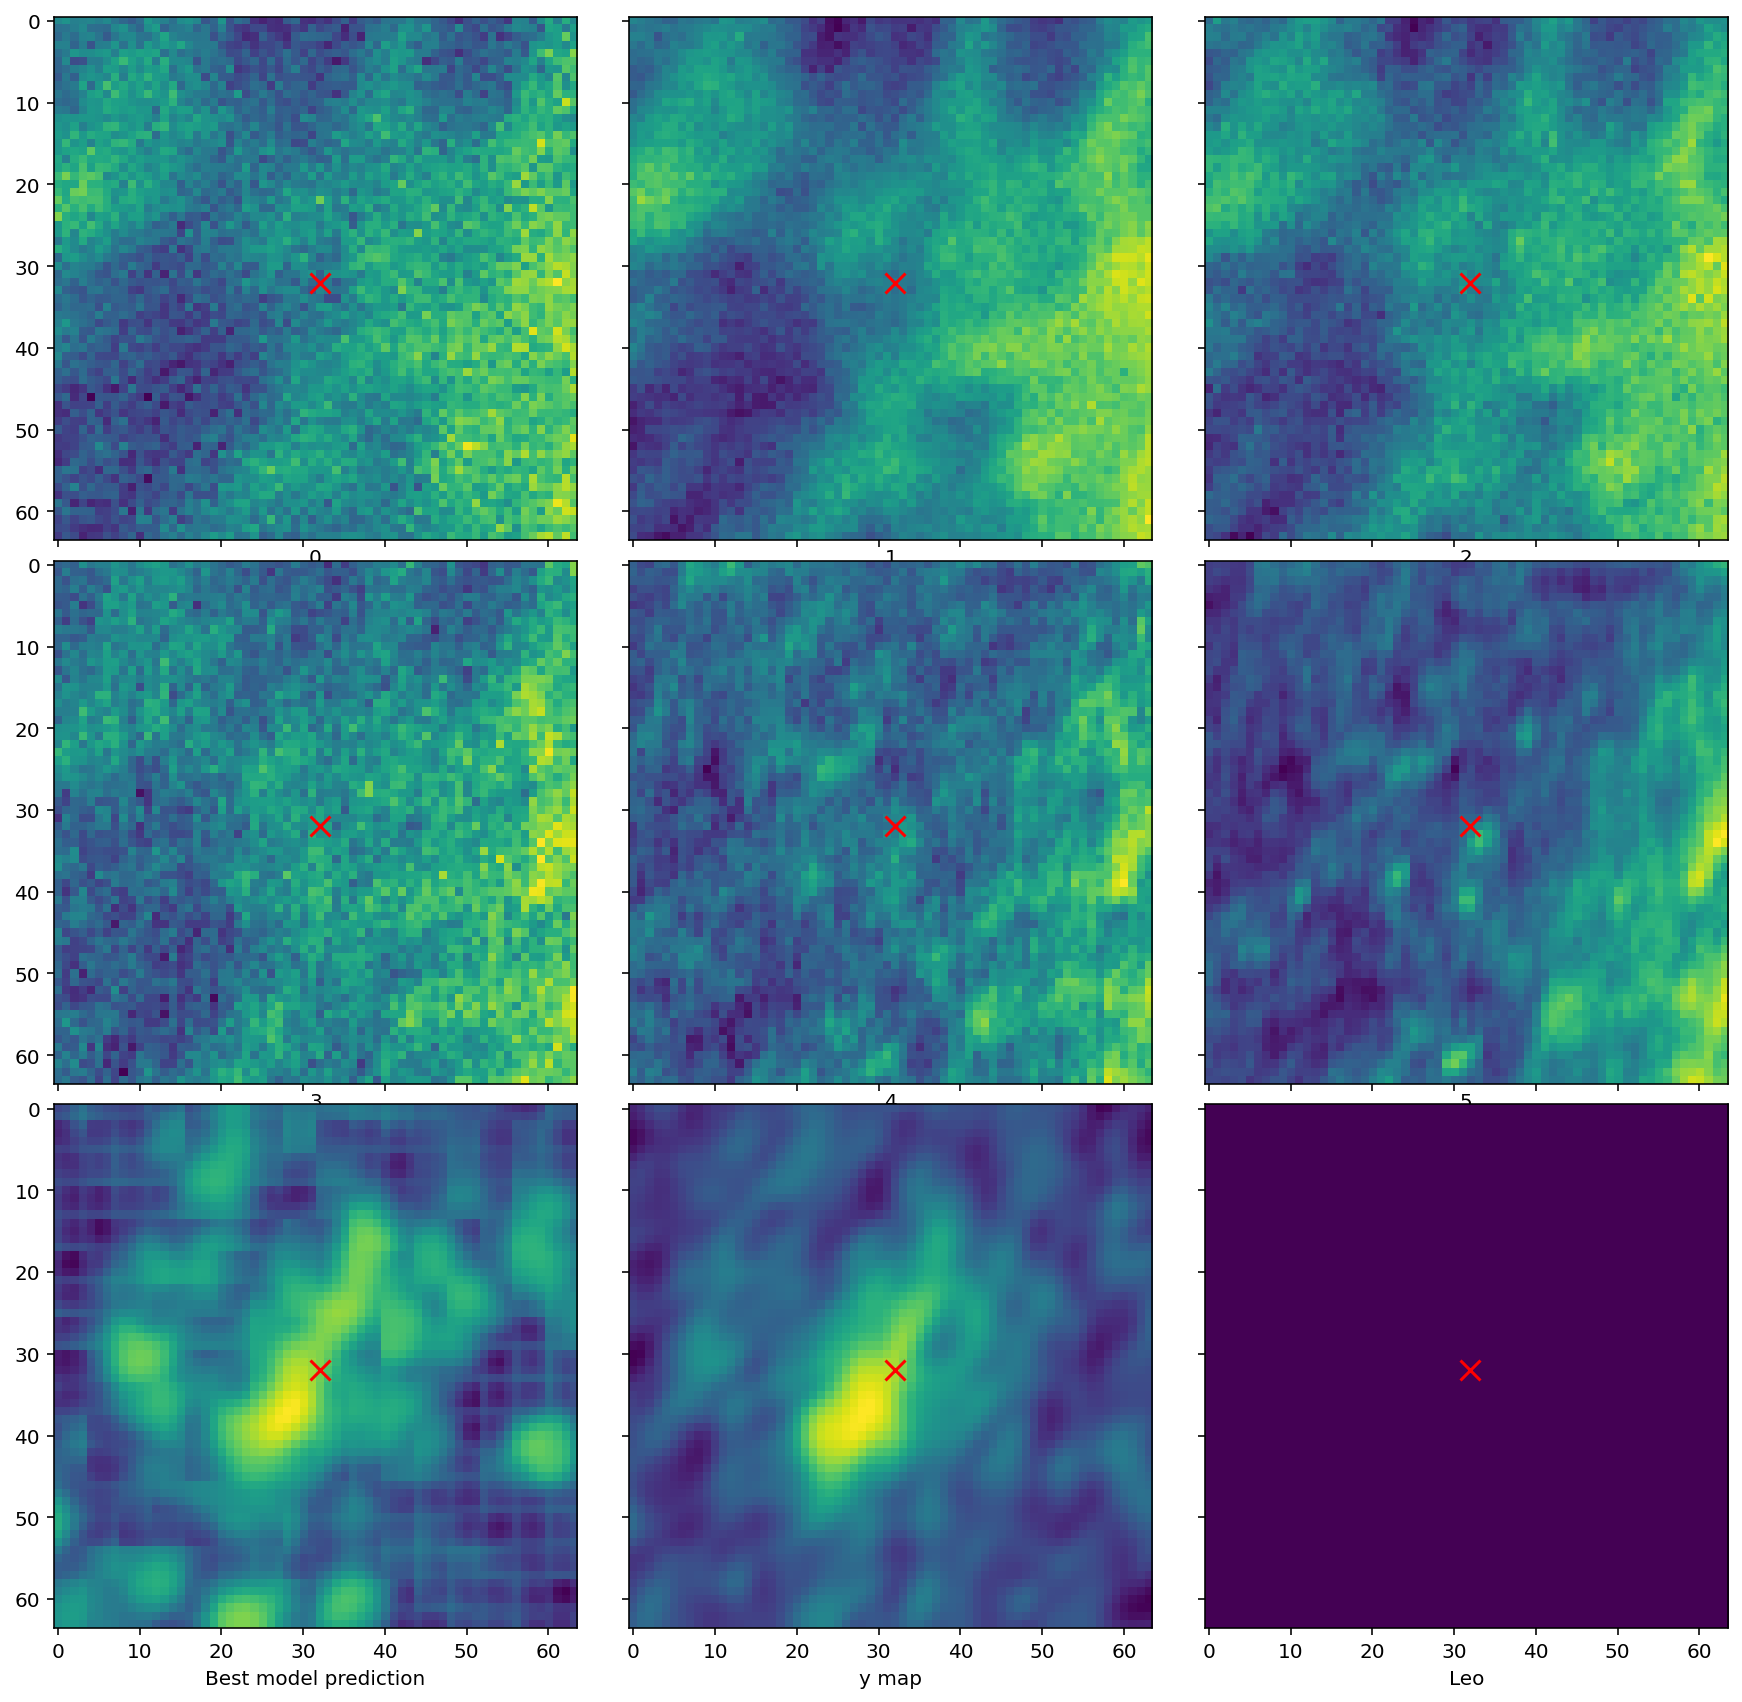

In [21]:
pic9()

RA      194.954
DEC     27.9806
name       Coma
pix2          3
pix     4191272
Name: 1, dtype: object
0 -3.8844351768493652 1.846129059791565
1 -3.1604862213134766 1.7855455875396729
2 -3.3757503032684326 1.6210918426513672
3 -3.601959466934204 2.229677200317383
4 -3.1318671703338623 2.2387852668762207
5 -3.152168035507202 1.8450489044189453


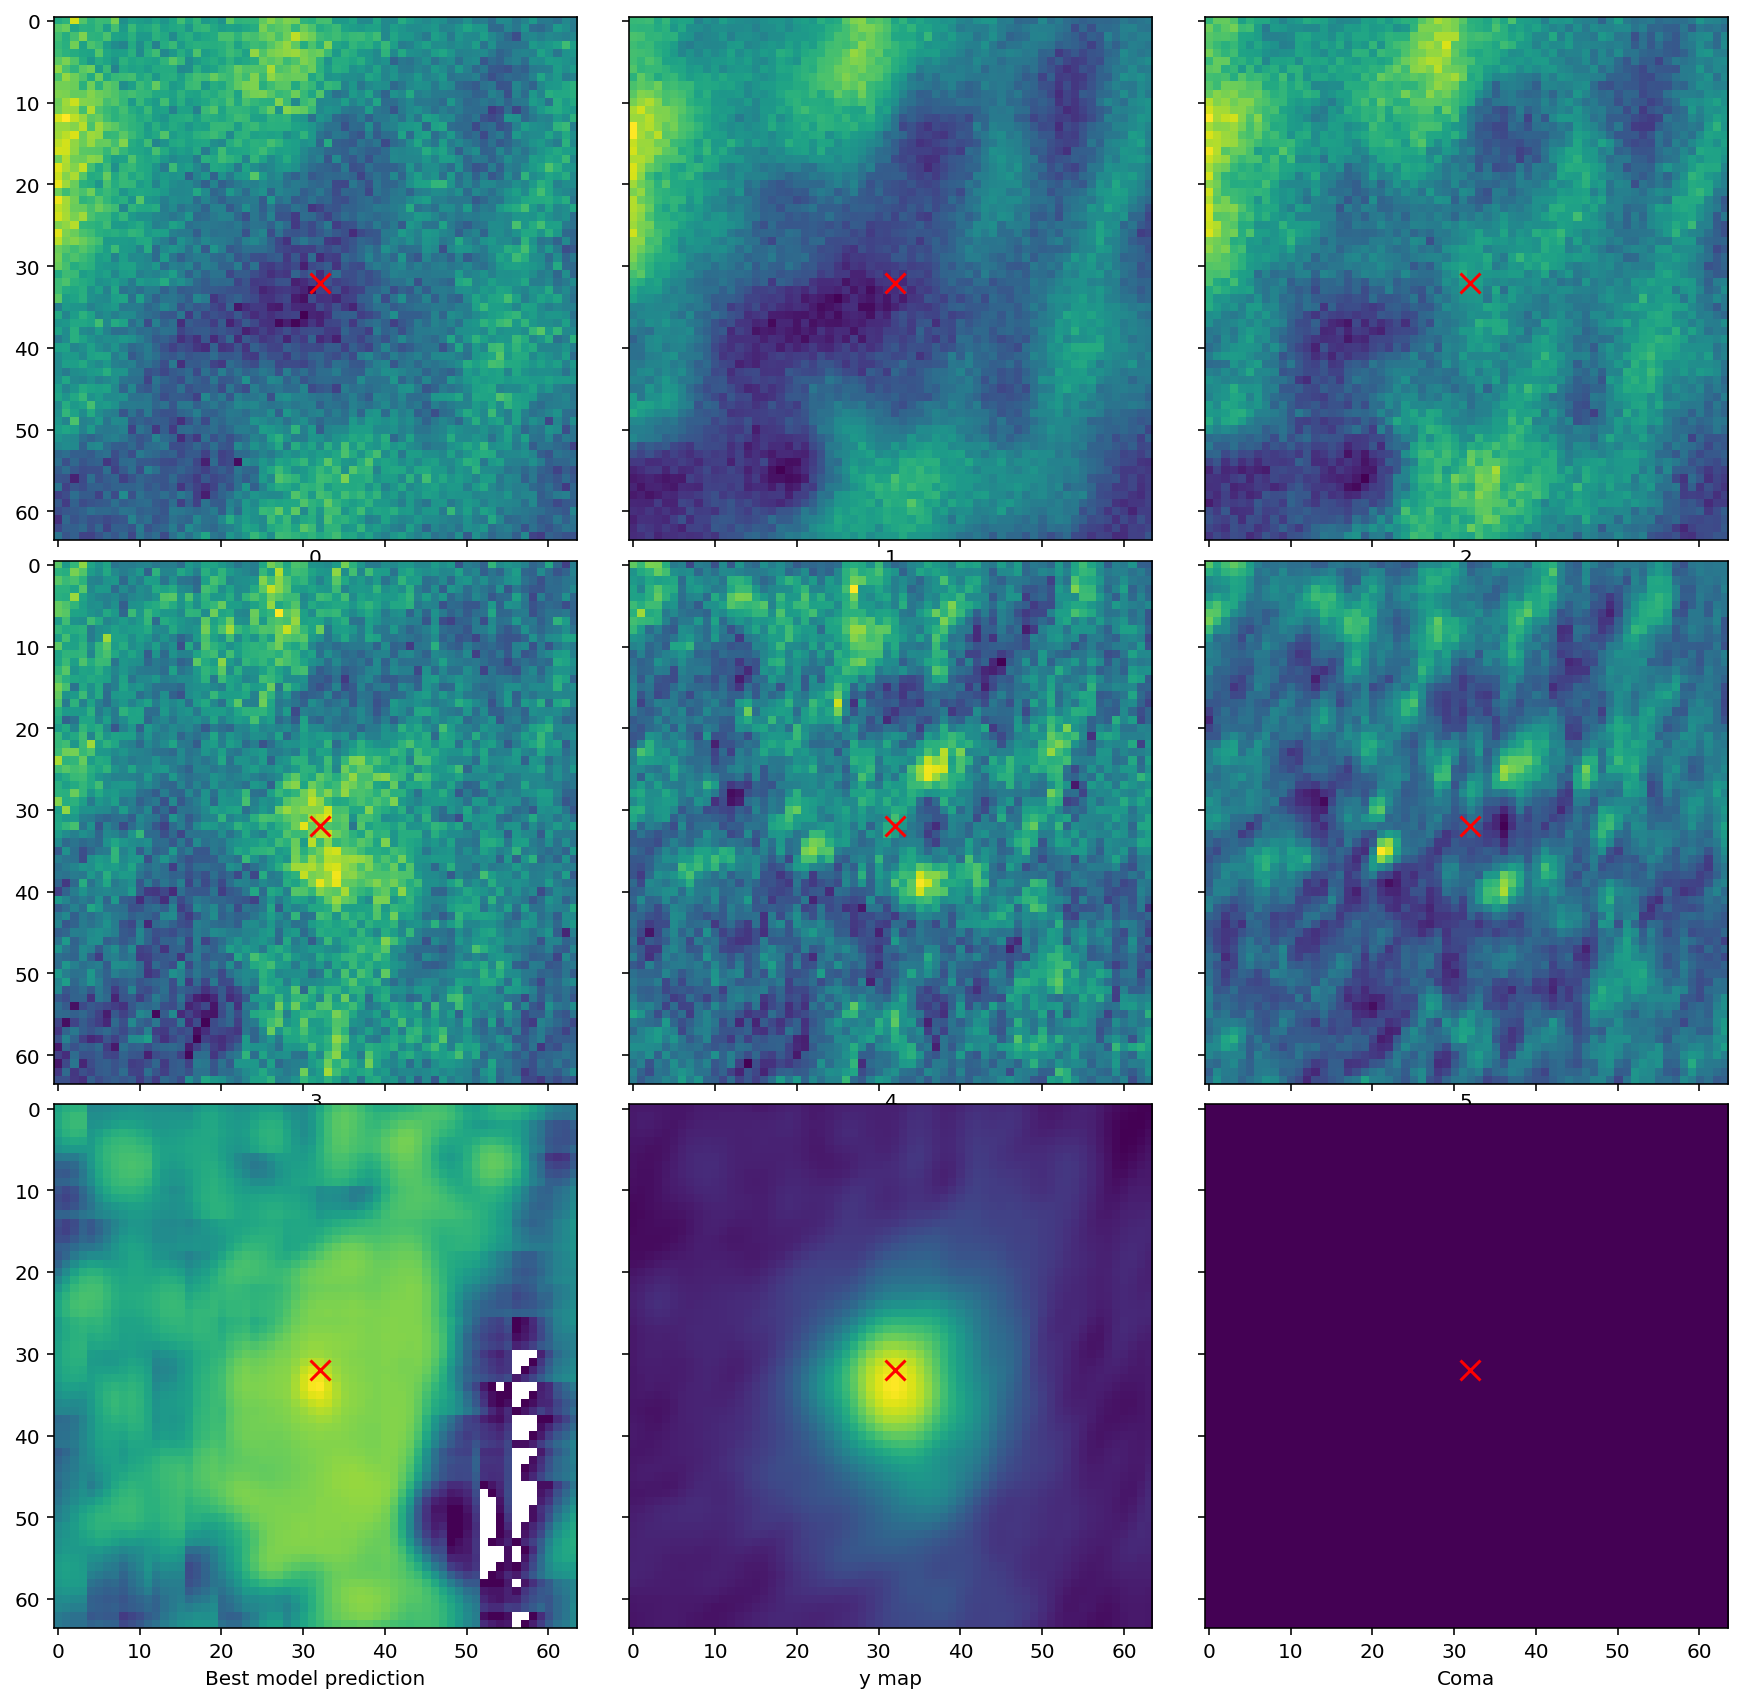

In [23]:
i = 1
line = df.iloc[i]
pix2 = line['pix2']
matr = one_pixel_fragmentation(2, pix2, 10)
mdict = matr2dict(matr)
all_connected = np.load('/home/rt2122/Data/cur/favourite_clusters/{pix2}.npy'.format(pix2=pix2))
pic, mask = draw_pic_with_mask(None, [], matr=matr)
ypic = draw_pic(matr, y=True)
cm1 = sns.light_palette("red", as_cmap=True)
cm2 = sns.light_palette("gray", as_cmap=True)
pic9()

RA        44.2583
DEC       13.0049
name    A399-A401
pix2           37
pix      39244338
Name: 2, dtype: object
0 -2.1993260383605957 3.7471396923065186
1 -1.8642224073410034 3.309687852859497
2 -0.9983000159263611 5.164531707763672
3 4.637883186340332 16.879968643188477
4 13.114047050476074 42.191123962402344
5 19.14731216430664 59.7073974609375


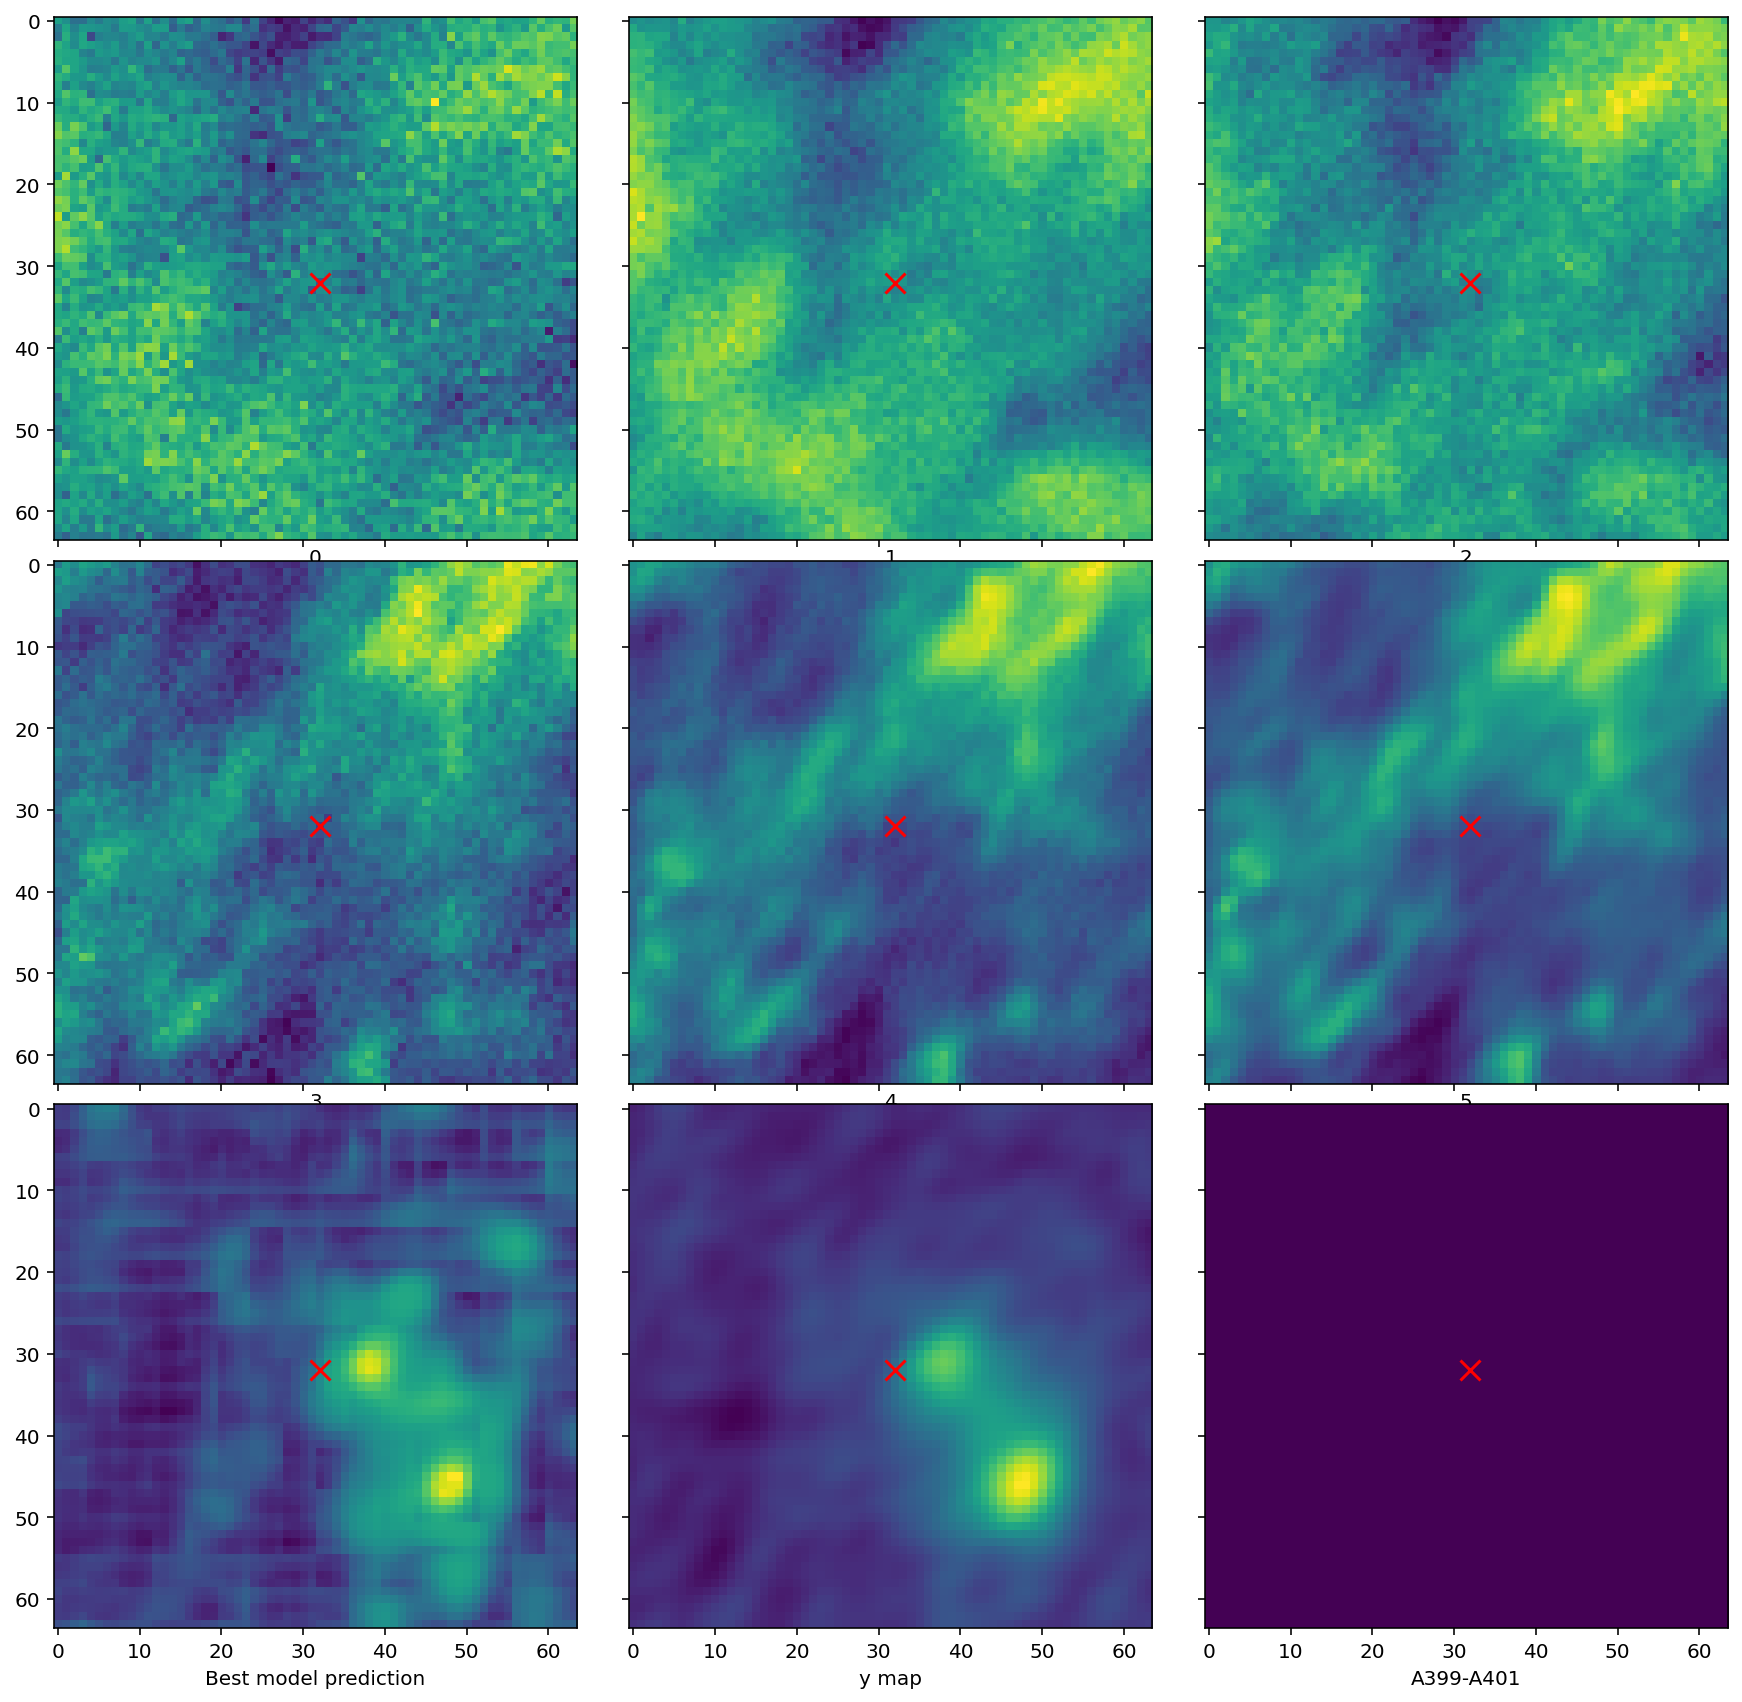

In [24]:
i = 2
line = df.iloc[i]
pix2 = line['pix2']
matr = one_pixel_fragmentation(2, pix2, 10)
mdict = matr2dict(matr)
all_connected = np.load('/home/rt2122/Data/cur/favourite_clusters/{pix2}.npy'.format(pix2=pix2))
pic, mask = draw_pic_with_mask(None, [], matr=matr)
ypic = draw_pic(matr, y=True)
cm1 = sns.light_palette("red", as_cmap=True)
cm2 = sns.light_palette("gray", as_cmap=True)
pic9()

RA        201.25
DEC          -30
name     Shapley
pix2          12
pix     13554718
Name: 3, dtype: object
0 -2.5766232013702393 1.9278403520584106
1 -2.0542562007904053 1.4472519159317017
2 -2.1946663856506348 1.9254640340805054
3 -1.1279293298721313 4.838728904724121
4 3.8674087524414062 16.144166946411133
5 7.3596510887146 28.768144607543945


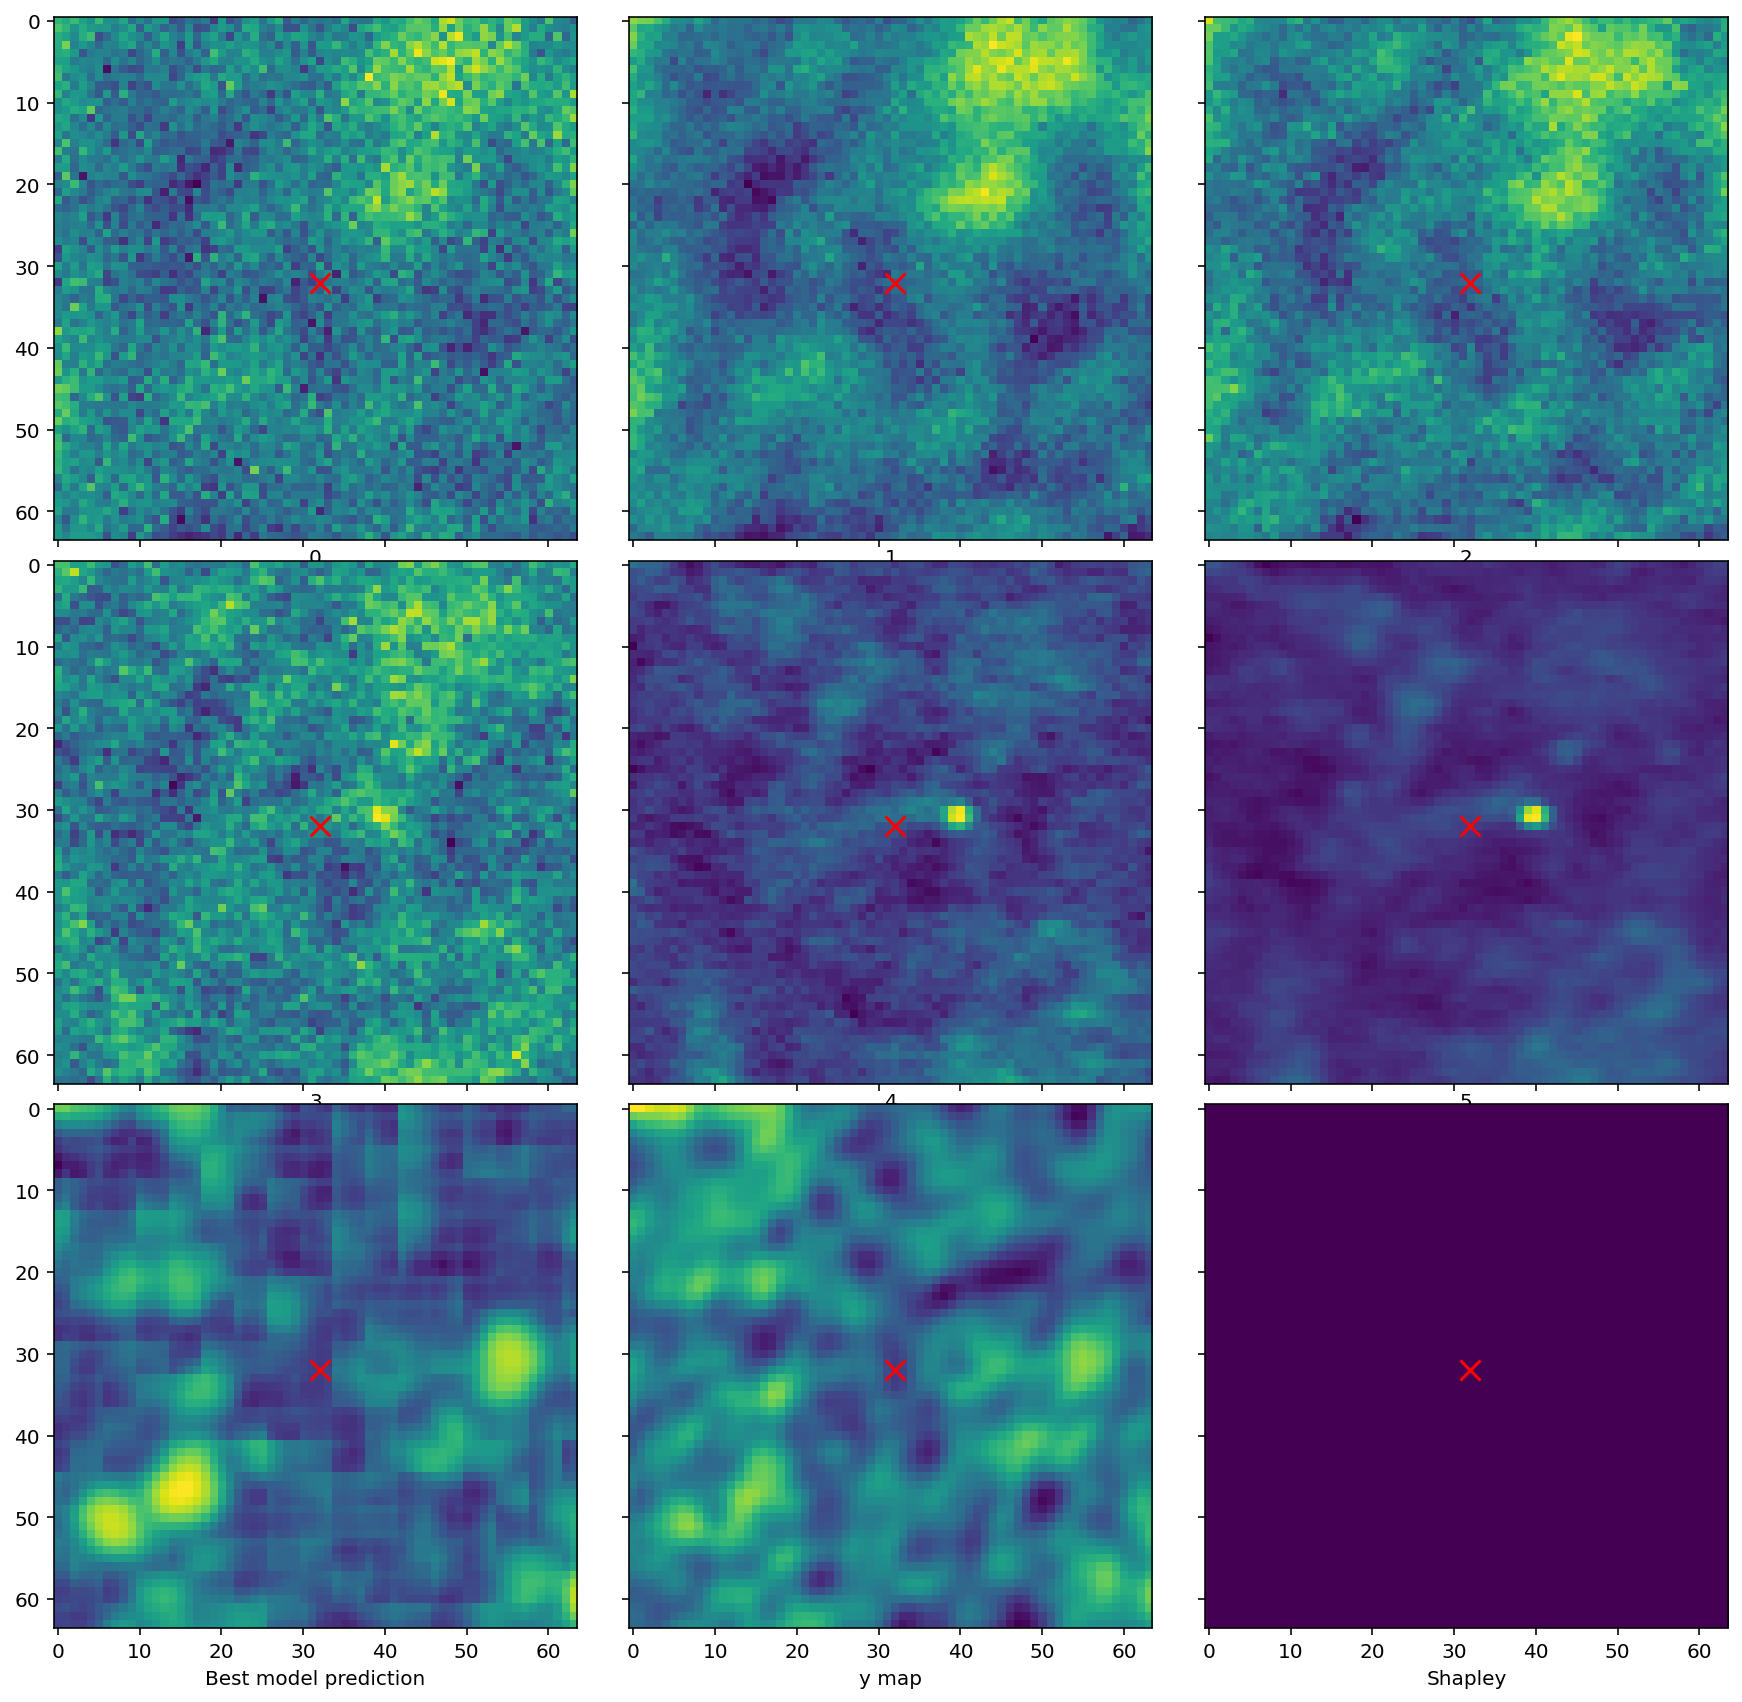

In [25]:
i = 3
line = df.iloc[i]
pix2 = line['pix2']
matr = one_pixel_fragmentation(2, pix2, 10)
mdict = matr2dict(matr)
all_connected = np.load('/home/rt2122/Data/cur/favourite_clusters/{pix2}.npy'.format(pix2=pix2))
pic, mask = draw_pic_with_mask(None, [], matr=matr)
ypic = draw_pic(matr, y=True)
cm1 = sns.light_palette("red", as_cmap=True)
cm2 = sns.light_palette("gray", as_cmap=True)
pic9()

RA          150.507
DEC         2.31204
name    G237.0+42.5
pix2              9
pix        10158405
Name: 4, dtype: object
0 -3.6594414710998535 0.9896504878997803
1 -3.2915701866149902 0.337890088558197
2 -3.472782850265503 0.5389397740364075
3 -3.233140230178833 2.7040438652038574
4 -2.001598358154297 8.766831398010254
5 -0.9649733304977417 12.269804000854492


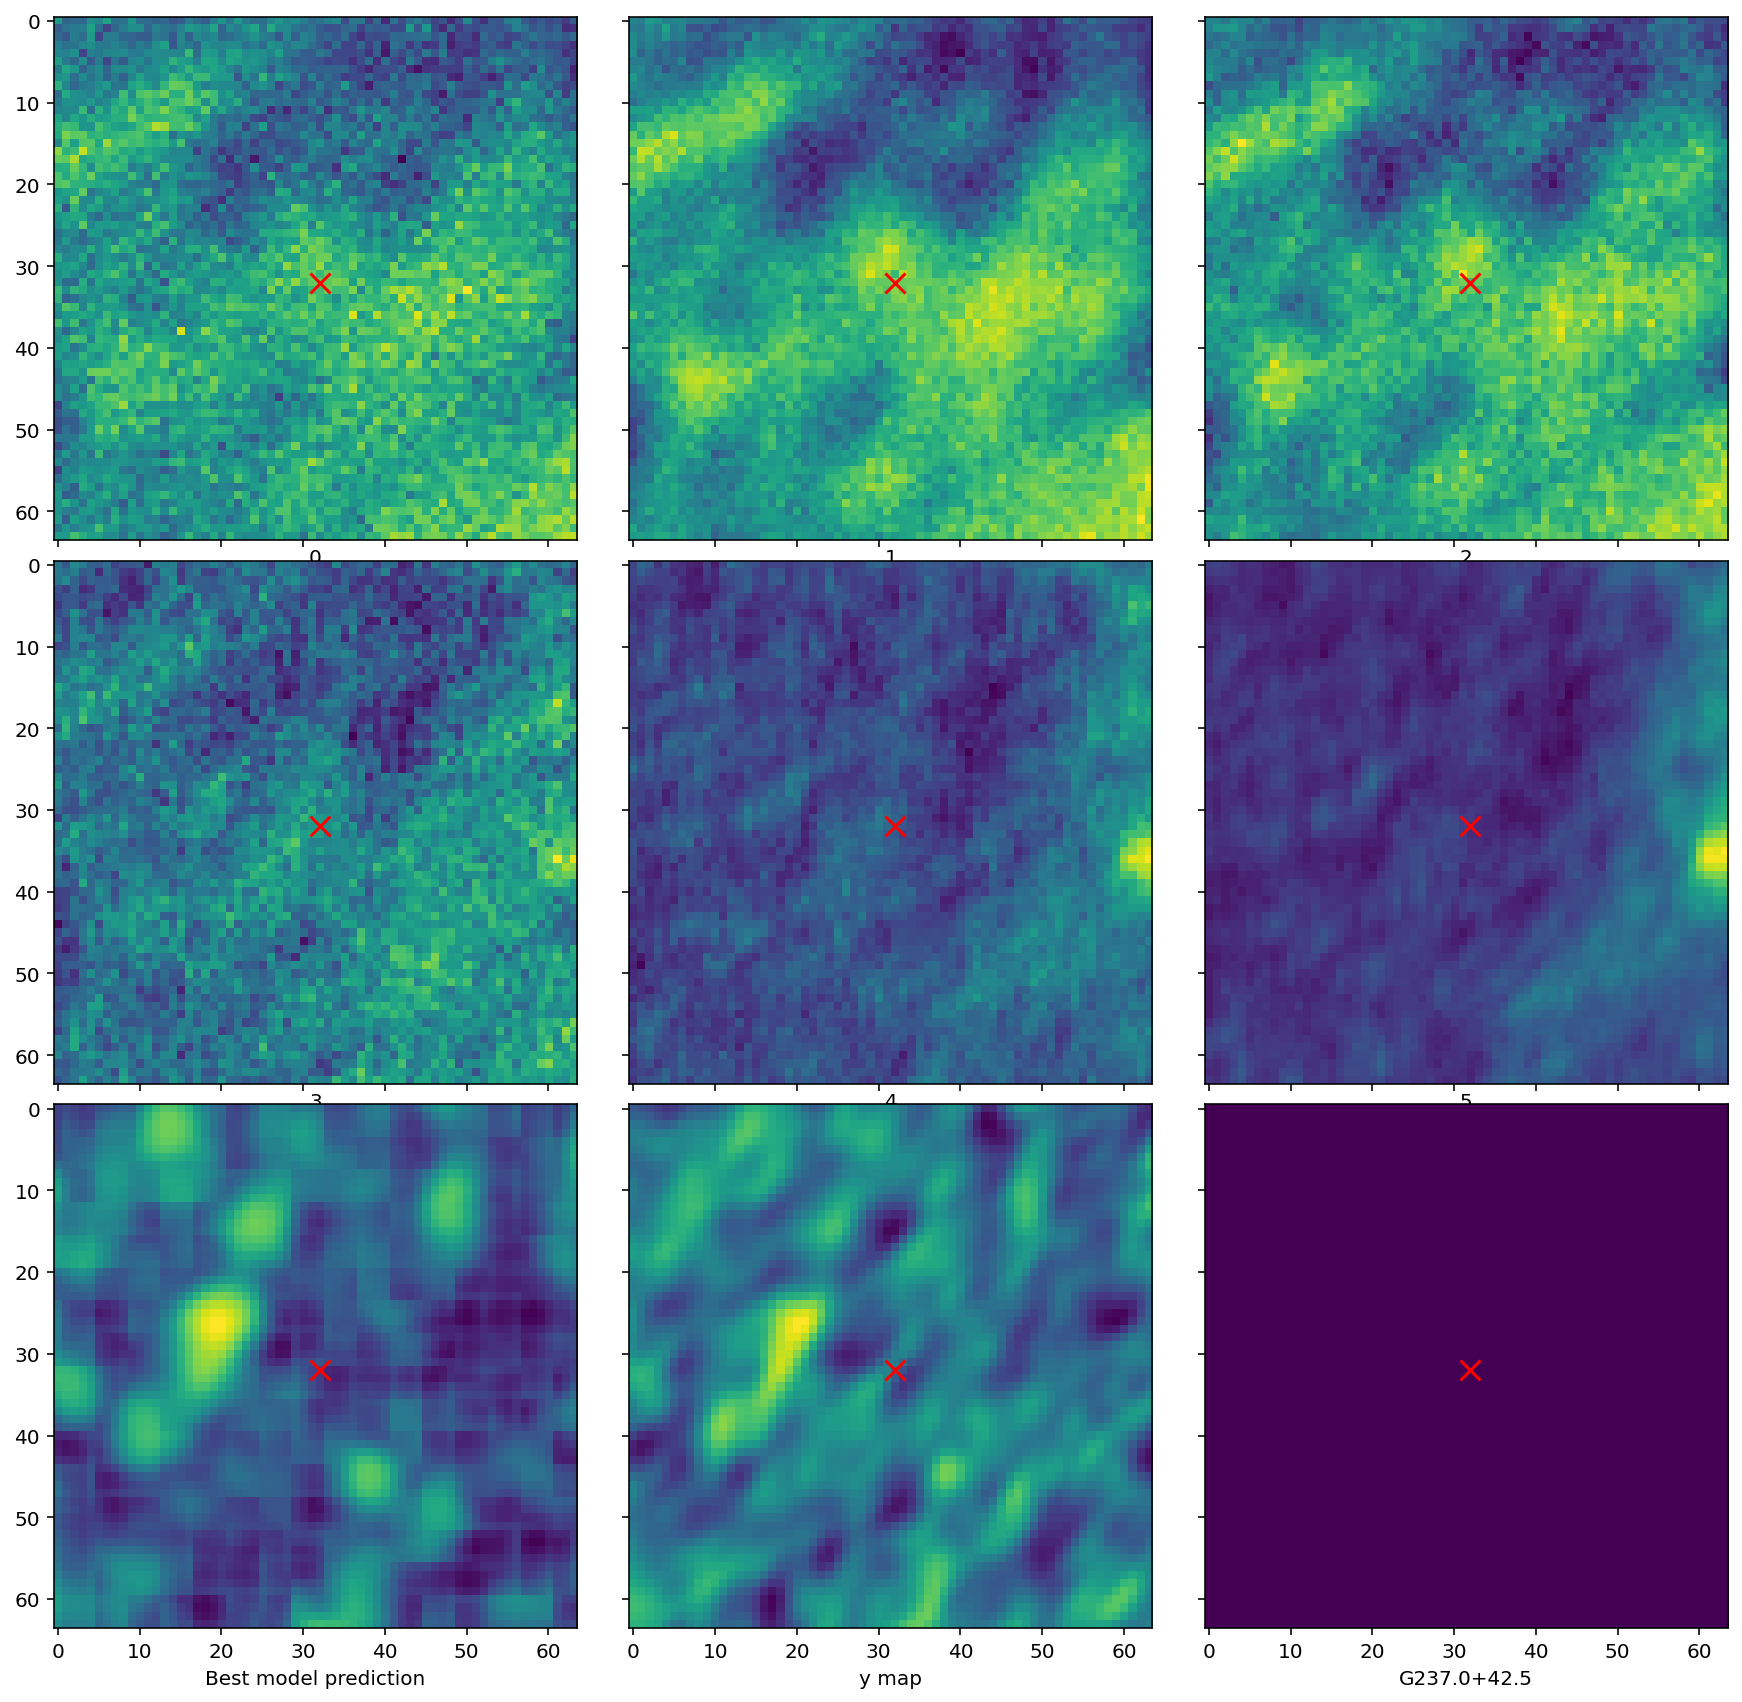

In [26]:
i = 4
line = df.iloc[i]
pix2 = line['pix2']
matr = one_pixel_fragmentation(2, pix2, 10)
mdict = matr2dict(matr)
all_connected = np.load('/home/rt2122/Data/cur/favourite_clusters/{pix2}.npy'.format(pix2=pix2))
pic, mask = draw_pic_with_mask(None, [], matr=matr)
ypic = draw_pic(matr, y=True)
cm1 = sns.light_palette("red", as_cmap=True)
cm2 = sns.light_palette("gray", as_cmap=True)
pic9()